In [1]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import matplotlib.pyplot as plt # this is used for the plot the graph 
%matplotlib inline
from tqdm import notebook
import tensorflow as tf
from scipy import stats
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings("ignore")
from mpl_toolkits.mplot3d.axes3d import get_test_data

from scipy.stats import vonmises


### Simulate data from circular normal distribution

In [2]:
np.random.seed(2021)

x=np.random.uniform(0.5,2,size=10000)

mu=[vonmises.rvs(kappa=i,size=1) for i in x] 

mu=np.array(mu).ravel()

y0=np.zeros(5000)
y1=np.zeros(5000)

for i in range(2):
    y0+=np.cos(mu[i*5000:(i+1)*5000])
    y1+=np.sin(mu[i*5000:(i+1)*5000])


y0=y0.reshape(-1,1)/2
y1=y1.reshape(-1,1)/2




In [3]:
#training data
x0=np.c_[x[:5000],x[5000:]]

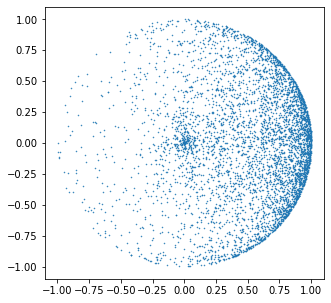

In [4]:
plt.figure(figsize=(5,5))
plt.plot(y0,y1,'.',markersize=1)

### Collaborating Network(CN)

In [5]:
def variables_from_scope(scope_name):
    """
    Returns a list of all trainable variables in a given scope. This is useful when
    you'd like to back-propagate only to weights in one part of the network
    (in our case, the generator or the discriminator).
    """
    return tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope=scope_name)

In [6]:
 # Graph parameters
intermediate_layer_size = 100
intermediate_layer_size2 = 80
intermediate_layer_size3 = 60
# Training parameters
batch_size = 256
pre_iter= 50000
iters= 50000

In [7]:
# f function learn the inverse of cdf
def f(x,q):
    """x:input feature and treatment,
    q:percentile,
    """
    z0=tf.concat([x,q],axis=1)
    hidden_layer = tf.compat.v1.layers.dense(z0, intermediate_layer_size, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=.001),name="f1", activation=tf.compat.v1.nn.elu,reuse=None)
    hidden_layer_bn = tf.compat.v1.layers.batch_normalization(hidden_layer,name="f1bn")
    hidden_layer2 = tf.compat.v1.layers.dense(hidden_layer_bn, intermediate_layer_size2, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=.001),name="f2", activation=tf.keras.activations.elu,reuse=None)
    hidden_layer2_bn = tf.compat.v1.layers.batch_normalization(hidden_layer2,name="f2bn")
    hidden_layer3 = tf.compat.v1.layers.dense(hidden_layer2_bn, intermediate_layer_size3, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=.001),name="f3", activation=tf.compat.v1.nn.elu,reuse=None)
    hidden_layer3_bn = tf.compat.v1.layers.batch_normalization(hidden_layer2,name="f3bn")
    yq = tf.compat.v1.layers.dense(hidden_layer3_bn,1,kernel_initializer=tf.keras.initializers.RandomNormal(stddev=.001), name="f4", activation=None,reuse=None)
    return yq

In [8]:
# g function learn the cdf
def g(yq,x):
    """
    yq:quantile:,
    x:input feature and treatment,
    """
    z1=tf.concat([yq,x],axis=1)
    hidden_layer = tf.compat.v1.layers.dense(z1, intermediate_layer_size,kernel_initializer=tf.compat.v1.initializers.random_normal(stddev=.001), name="g1", activation=tf.compat.v1.nn.elu,reuse=None)
    hidden_layer_bn = tf.compat.v1.layers.batch_normalization(hidden_layer,name="g1bn")
    hidden_layer2 = tf.compat.v1.layers.dense(hidden_layer_bn, intermediate_layer_size2, kernel_initializer=tf.compat.v1.initializers.random_normal(stddev=.001),name="g2", activation=tf.compat.v1.nn.elu,reuse=None)
    hidden_layer2_bn = tf.compat.v1.layers.batch_normalization(hidden_layer2,name="g2bn")
    gq_logit = tf.compat.v1.layers.dense(hidden_layer2_bn, 1,kernel_initializer=tf.initializers.glorot_normal, name="g3", activation=None,reuse=None)
    gq_logit_bn=tf.keras.layers.BatchNormalization(axis=-1,momentum=.1,trainable=False)(gq_logit)*tf.math.sqrt(3.29)
    return gq_logit_bn

In [9]:
tf.compat.v1.disable_eager_execution()

In [10]:

tf.compat.v1.reset_default_graph()

# Placeholders
y_ = tf.compat.v1.placeholder(tf.float32, [None, 1])

pre_y= tf.compat.v1.placeholder(tf.float32, [None, 1])
x_=tf.compat.v1.placeholder(tf.float32, [None, 2])
q_ = tf.compat.v1.placeholder(tf.float32, [None, 1])


# f
with tf.compat.v1.variable_scope("f") as scope:
    yq_= f(x_,q_)


ylessthan= tf.cast(tf.less_equal(y_,yq_),tf.float32)
ylessthan_pre= tf.cast(tf.less_equal(y_,pre_y),tf.float32)


with tf.compat.v1.variable_scope("g") as scope:
    gq_logit = g(yq_,x_)
    gq=tf.sigmoid(gq_logit)
    scope.reuse_variables()
    gq_logit_pre = g(pre_y,x_)


#Losses
f_loss = tf.reduce_mean(tf.square(q_-gq))
g_loss = 1*tf.compat.v1.losses.sigmoid_cross_entropy(ylessthan,gq_logit)

#pre-loss
g_loss_pre = tf.compat.v1.losses.sigmoid_cross_entropy(ylessthan_pre,gq_logit_pre)

# Optimizer
optimizerg = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)
optimizerf = tf.compat.v1.train.AdamOptimizer(learning_rate=5e-4)


pre_step= optimizerg.minimize(g_loss_pre,var_list=variables_from_scope("g"))
g_step = optimizerg.minimize(g_loss, var_list=variables_from_scope("g"))
f_step = optimizerf.minimize(f_loss, var_list=variables_from_scope("f"))

# Initializer
initialize_all = tf.compat.v1.global_variables_initializer()

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


### Fit Y0 first, the first layer p(Y0|X)

In [12]:
sess = tf.compat.v1.Session()
sess.run(initialize_all)
gl=[]
fl=[]

xtrain=x0

for k in notebook.tnrange(pre_iter):
    i=np.random.choice(len(xtrain),batch_size,replace=False)
    ytmp = y0[i,:]
    xtmp= x0[i,:]
    #when we do not have f initially, we use a uniform distribution to extract points from support
    pre_ytmp=np.random.uniform(-1.1,1.1,(batch_size,1))  
    _,glt=sess.run([pre_step,g_loss_pre],feed_dict={y_: ytmp,
                                x_:xtmp,
                                pre_y:pre_ytmp})
    
    gl.append(glt)

for t in notebook.tnrange(iters):
    #randomly generate a minibatch from valid set
    i=np.random.choice(len(xtrain),batch_size,replace=False)
    qtmp=np.random.uniform(0, 1.0, [batch_size, 1])
    ytmp = y0[i,:]
    xtmp= x0[i,:]
    
    _,glt=sess.run([g_step,g_loss], feed_dict={y_: ytmp,
                                x_:xtmp,
                                q_:qtmp})
    gl.append(glt)
    
    for i in range(0,2):
        i=np.random.choice(len(xtrain),batch_size,replace=False)
        qtmp=np.random.uniform(0, 1.0, [batch_size, 1])
        ytmp = y0[i,:]
        xtmp= x0[i,:]
        _,flt=sess.run([f_step,f_loss],feed_dict={y_: ytmp,
                                x_:xtmp,
                                q_:qtmp})
    fl.append(flt)

    

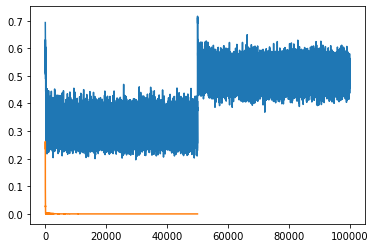

In [13]:
plt.plot(gl)
plt.plot(fl)

### Extract y0 first

In [14]:
# generate mu, uniform
np.random.seed(2021)
xtest0=np.random.uniform(0.5,2,size=2)



#draw 4000 samples
y0pred=sess.run(gq,feed_dict={x_:np.tile(xtest0,(10000,1)),
                                yq_:np.linspace(-1,1,10000).reshape(-1,1)})

y0pred[0]=0
y0pred[1]=1

y0sample=interp1d(y0pred.ravel(),np.linspace(-1,1,10000))(np.random.uniform(0,1,5000))


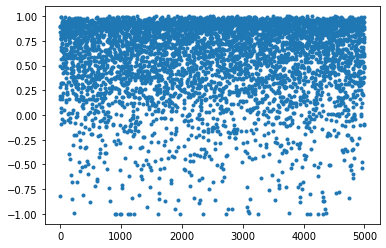

In [15]:
plt.plot(y0sample,'.')

In [16]:
xtest0

array([1.40896742, 1.60005404])

In [17]:
x1=np.c_[x0,y0]

### second training , p(Y1|Y0,X)

In [18]:

tf.compat.v1.reset_default_graph()

# Placeholders
y_ = tf.compat.v1.placeholder(tf.float32, [None, 1])

pre_y= tf.compat.v1.placeholder(tf.float32, [None, 1])
x_=tf.compat.v1.placeholder(tf.float32, [None, 3])
q_ = tf.compat.v1.placeholder(tf.float32, [None, 1])


# f
with tf.compat.v1.variable_scope("f") as scope:
    yq_= f(x_,q_)


ylessthan= tf.cast(tf.less_equal(y_,yq_),tf.float32)
ylessthan_pre= tf.cast(tf.less_equal(y_,pre_y),tf.float32)


with tf.compat.v1.variable_scope("g") as scope:
    gq_logit = g(yq_,x_)
    gq=tf.sigmoid(gq_logit)
    scope.reuse_variables()
    gq_logit_pre = g(pre_y,x_)


#Losses
f_loss = tf.reduce_mean(tf.square(q_-gq))
g_loss = 1*tf.compat.v1.losses.sigmoid_cross_entropy(ylessthan,gq_logit)

#pre-loss
g_loss_pre = tf.compat.v1.losses.sigmoid_cross_entropy(ylessthan_pre,gq_logit_pre)

# Optimizer
optimizerg = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)
optimizerf = tf.compat.v1.train.AdamOptimizer(learning_rate=5e-4)


pre_step= optimizerg.minimize(g_loss_pre,var_list=variables_from_scope("g"))
g_step = optimizerg.minimize(g_loss, var_list=variables_from_scope("g"))
f_step = optimizerf.minimize(f_loss, var_list=variables_from_scope("f"))

# Initializer
initialize_all = tf.compat.v1.global_variables_initializer()



sess = tf.compat.v1.Session()
sess.run(initialize_all)
gl=[]
fl=[]


for k in notebook.tnrange(pre_iter):
    i=np.random.choice(len(x1),batch_size,replace=False)
    ytmp = y1[i,:]
    xtmp= x1[i,:]
    #when we do not have f initially, we use a uniform distribution to extract points from support
    
    bound=np.sqrt(1-ytmp.ravel()**2)
    pre_ytmp=np.random.uniform(-bound-0.1,bound+0.1).reshape(-1,1)  
    _,glt=sess.run([pre_step,g_loss_pre],feed_dict={y_: ytmp,
                                x_:xtmp,
                                pre_y:pre_ytmp})
    
    gl.append(glt)

for t in notebook.tnrange(iters):
    #randomly generate a minibatch from valid set
    i=np.random.choice(len(x1),batch_size,replace=False)
    qtmp=np.random.uniform(0, 1.0, [batch_size, 1])
    ytmp = y1[i,:]
    xtmp= x1[i,:]
    
    _,glt=sess.run([g_step,g_loss], feed_dict={y_: ytmp,
                                x_:xtmp,
                                q_:qtmp})
    gl.append(glt)
    
    for i in range(0,2):
        i=np.random.choice(len(x1),batch_size,replace=False)
        qtmp=np.random.uniform(0, 1.0, [batch_size, 1])
        ytmp = y1[i,:]
        xtmp= x1[i,:]
        _,flt=sess.run([f_step,f_loss],feed_dict={y_: ytmp,
                                x_:xtmp,
                                q_:qtmp})
    fl.append(flt)

    


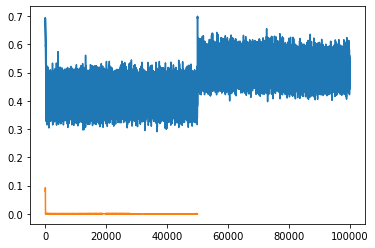

In [19]:
plt.plot(gl)
plt.plot(fl)

#### Extract y1

In [20]:
# generate mu, uniform
xtest1=np.c_[np.tile(xtest0,(5000,1)),y0sample]

y1sample=[]


#draw 2000 samples
for i in range(5000):
    bound=np.sqrt(1-xtest1[i,-1]**2)
    y1pred=sess.run(gq,feed_dict={x_:np.tile(xtest1[i],(3000,1)),
                                    yq_:np.linspace(-bound,bound,3000).reshape(-1,1)})

    y1pred[0]=0
    y1pred[1]=1

    y1sampletmp=interp1d(y1pred.ravel(),np.linspace(-bound,bound,3000))(np.random.uniform(size=1))
    y1sample.append(y1sampletmp)
y1sample=np.array(y1sample).ravel()


### comparing scatter plot and cdf between the estimated and the truth

Text(0.5, 0, '$Y_0$')

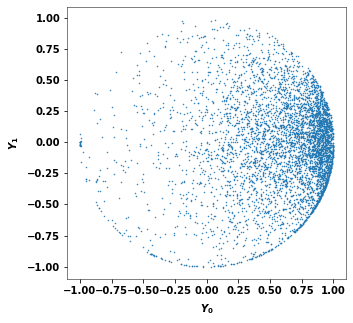

In [29]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.labelpad"] = 6


plt.rcParams['axes.linewidth'] = 0.5


plt.rcParams['axes.labelsize'] = 10

plt.rcParams['axes.titlesize'] = 12

plt.rcParams['xtick.labelsize'] = 10

plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 9.5


fig=plt.figure(figsize=(5,5))
plt.plot(y0sample,y1sample,'.',markersize=1)



plt.ylabel(r'$Y_1$')

plt.xlabel(r'$Y_0$')



# fig.savefig(r'scatter_est.pdf',transparent=True,bbox_inches = 'tight',
#      pad_inches = 0.1)

In [24]:

mu0=[vonmises.rvs(kappa=xtest0[0],size=1) for i in range(5000)] 
mu1=[vonmises.rvs(kappa=xtest0[1],size=1) for i in range(5000)] 



mu0=np.array(mu0).ravel()
mu1=np.array(mu1).ravel()



y0tmp=(np.cos(mu0)+np.cos(mu1))/2
y1tmp=(np.sin(mu0)+np.sin(mu1))/2



In [25]:
truedata=np.c_[y0sample,y1sample]

Text(0.5, 0, '$Y_0$')

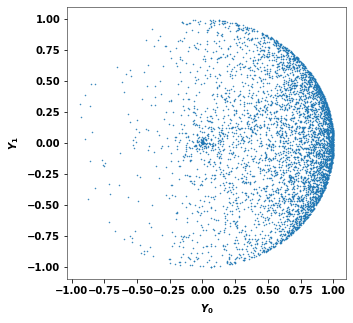

In [30]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.labelpad"] = 6


plt.rcParams['axes.linewidth'] = 0.5


plt.rcParams['axes.labelsize'] = 10

plt.rcParams['axes.titlesize'] = 12

plt.rcParams['xtick.labelsize'] = 10

plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 9.5


fig=plt.figure(figsize=(5,5))
plt.plot(y0tmp,y1tmp,'.',markersize=1)



plt.ylabel(r'$Y_1$')

plt.xlabel(r'$Y_0$')

# plt.show()
# fig.savefig(r'scatter_true.pdf',transparent=True,bbox_inches = 'tight',
#      pad_inches = 0.1)


### Plot the joint density

In [36]:
# Define the borders
y0min = min(y0sample)
y0max = max(y0sample) 
y1min = min(y1sample) 
y1max = max(y1sample) 
print(y0min, y0max, y1min, y1max)
# Create meshgrid
yy0, yy1 = np.mgrid[y0min:y0max:50j, y1min:y1max:50j]

-0.9999997723850036 0.9997506529035728 -0.9995781853360061 0.9848541264512369


In [37]:
rv = stats.multivariate_normal([xtest0[0], 0], [[1, 0.5], [0.5, 1]])

In [38]:
positions = np.vstack([yy0.ravel(), yy1.ravel()])

f = np.array([np.mean((y0sample<positions[0,i])*(y1sample<positions[1,i])) for i in range(2500)])

In [39]:
f=f.reshape(yy0.shape)

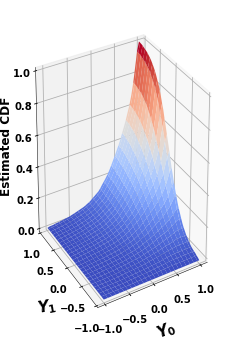

In [44]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.labelpad"] = 6


plt.rcParams['axes.linewidth'] = 0.5


plt.rcParams['axes.labelsize'] = 10

plt.rcParams['axes.titlesize'] = 12

plt.rcParams['xtick.labelsize'] = 10

plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 9.5


fig = plt.figure(figsize=(4, 6))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(yy0, yy1, f, rstride=2, cstride=2, cmap='coolwarm', edgecolor='none')
#surf1 = ax.plot_surface(yy0, yy1, qqq, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')

ax.yaxis.set_rotate_label(False) 

ax.set_xlabel('$Y_0$',fontsize=15)
ax.set_ylabel('$Y_1$',fontsize=15,rotation = 10)

#ax.set_zlim(0,0.175)
ax.set_ylim(-1,1)


ax.zaxis.set_rotate_label(False) 

ax.set_zlabel('Estimated CDF', fontsize=12, rotation = 90)
ax.set_zlim(0,1)



#fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(25, -120)

# fig.savefig(r'est2dcdf.pdf',transparent=True,bbox_inches = 'tight',
#     pad_inches = 0.1)
pass

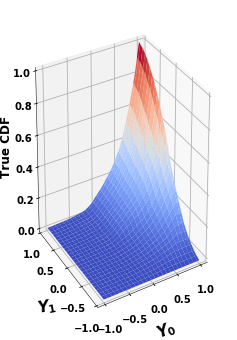

In [45]:
truecdf = np.array([np.mean((y0tmp<positions[0,i])*(y1tmp<positions[1,i])) for i in range(2500)]).reshape(yy0.shape)

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.labelpad"] = 6


plt.rcParams['axes.linewidth'] = 0.5


plt.rcParams['axes.labelsize'] = 10

plt.rcParams['axes.titlesize'] = 12

plt.rcParams['xtick.labelsize'] = 10

plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 9.5


fig = plt.figure(figsize=(4, 6))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(yy0, yy1, truecdf, rstride=2, cstride=2, cmap='coolwarm', edgecolor='none')
#surf1 = ax.plot_surface(yy0, yy1, qqq, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')

ax.yaxis.set_rotate_label(False) 

ax.set_xlabel('$Y_0$',fontsize=15)


ax.set_ylabel('$Y_1$',fontsize=15,rotation = 10)

#ax.set_zlim(0,0.175)
ax.set_zlim(0,1)
ax.set_ylim(-1,1)



ax.zaxis.set_rotate_label(False) 

ax.set_zlabel('True CDF', fontsize=12, rotation = 90)


ax.view_init(25, -120)
# fig.savefig(r'true2dcdf.pdf',transparent=True,bbox_inches = 'tight',
#      pad_inches = 0.1)
